In [1]:
import torch
device = (
    #Nvidia GPU
    "cuda"
    if torch.cuda.is_available()
    #Apple GPU
    else "mps"
    if torch.backends.mps.is_available()
    #Other
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


1. Import the Fashion MNIST dataset including the data labels. This would import two sets (training set and test set). Create a third set (validation set) by splitting the training set into two (training set and validation set) for validation purposes. Decide what a good ratio of training/validation is, and motivate your choice. You should use the validation set to evaluate the different choices you make when building your CNNs. Keep in mind that the test set will only be used at the very final stage and will not be included in the validation step.

In [2]:
from torchvision.transforms import ToTensor
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from matplotlib import pyplot as plt

#NOTE: data is not normalised yet
train_data = datasets.FashionMNIST('Data', download=True, train=True, transform=ToTensor())
test_data = datasets.FashionMNIST('Data', download=True, train=False, transform=ToTensor())

splitlength = [50000,10000]
#NOTE: This needs to be changed to be calculated using a percentage if we are going to have variable data lenghts (due to e.g. data augmentation)
train_data, val_data = random_split(train_data, splitlength)

batch_size = 32
train_dataloader = DataLoader(train_data, batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 13743861.04it/s]


Extracting Data/FashionMNIST/raw/train-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273076.55it/s]


Extracting Data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4888245.27it/s]


Extracting Data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to Data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 25674526.74it/s]


Extracting Data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to Data/FashionMNIST/raw



torch.Size([1, 28, 28]) 5


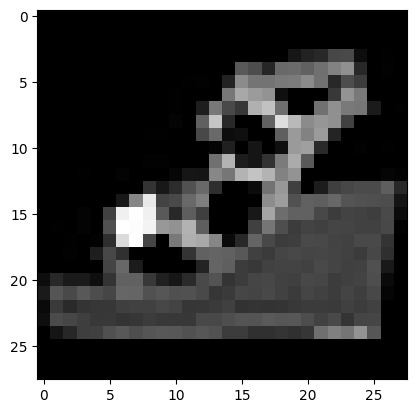

In [ ]:
image, label = train_data[0]
print(image.shape, label)
plt.imshow(image[0], cmap = 'gray')

2. Recreate the LeNet-5 architecture as your baseline. The model takes as input a greyscale image of size 28x28x1 and has 10 outputs, one for each class. Make sure all parameters (number of neurons, number and size of kernels) is the same as in the original architecture. You may assume that no zero-padding was applied. The model is trained using cross-entropy loss, Adam optimizer with a learning rate of 0.001. Use torch.nn.init.kaiming_uniform to initialize your weights. Use a batch size of 32, unless your hardware doesn't allow you to. Then reduce the size accordingly.


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(16 * 5 * 5, 120),  # 16 channels, 5x5 feature map size
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

In [ ]:
from torchkeras import summary

model = LeNet5()

def check_weights():
    for param in model.parameters():
        print(param.data)

def summarize(model):
    summary(model=model, input_shape=(1,28,28))

summarize(model)


--------------------------------------------------------------------------
Layer (type)                            Output Shape              Param #
Conv2d-1                             [-1, 6, 28, 28]                  156
ReLU-2                               [-1, 6, 28, 28]                    0
AvgPool2d-3                          [-1, 6, 14, 14]                    0
Conv2d-4                            [-1, 16, 10, 10]                2,416
ReLU-5                              [-1, 16, 10, 10]                    0
AvgPool2d-6                           [-1, 16, 5, 5]                    0
Flatten-7                                  [-1, 400]                    0
Linear-8                                   [-1, 120]               48,120
ReLU-9                                     [-1, 120]                    0
Linear-10                                   [-1, 84]               10,164
ReLU-11                                     [-1, 84]                    0
Linear-12                            

In [4]:
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def train(loader, model, criterion, optimizer):
    size = len(loader.dataset)
    batches = len(loader)
    model.train()
    loss_list = []
    total_loss = 0

    for n, batch in enumerate(tqdm(loader)):
        X,y = batch
        optimizer.zero_grad()

        pred = model(X)
        loss = criterion(pred, y)

        loss.backward()
        optimizer.step()

def test(loader, model, criterion):
    size = len(loader.dataset)
    batches = len(loader)
    total_loss = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for batch in loader:
            X,y = batch
            pred = model(X)

            loss = criterion(pred, y)
            total_loss += loss.item()

            y = y.data.numpy()
            y_true.extend(y)
            pred = pred.argmax(1).data.numpy()
            y_pred.extend(pred)

    loss = total_loss / batches
    accuracy = accuracy_score(y_true, y_pred)

    print(f"loss: {loss}\naccuracy: {accuracy}")
    return y_true, y_pred, loss


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd

model = LeNet5()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []
accuracy_train = []
accuracy_test = []

def train_test_loop(model, criterion, optimizer, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}\n----------------")
        print("Training:")
        train(loader=train_dataloader, model=model, criterion=criterion, optimizer=optimizer)

        print("Testing (train-set):")
        y_true_train, y_pred_train, loss_train = test(loader=train_dataloader, model=model, criterion=criterion)
        print("Testing (test set):")
        y_true_test, y_pred_test, loss_test = test(loader=val_dataloader, model=model, criterion=criterion)

        accuracy_train.append(accuracy_score(y_true_train, y_pred_train))
        accuracy_test.append(accuracy_score(y_true_test, y_pred_test))

        losses_train.append(loss_train)
        losses_test.append(loss_test)

    plot_loss(losses_train, losses_test, epochs)
    plot_accuracy(accuracy_train, accuracy_test, epochs)
    return y_true_test, y_pred_test

    print("----------------")

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)
    conf_matrix = pd.DataFrame(conf_matrix, classes, classes)
    sn.heatmap(conf_matrix, annot=True, fmt= 'g')
    cr = classification_report(y_true, y_pred, target_names=classes)
    print(cr)

def plot_accuracy(train_acc, test_acc, epochs):
    plt.plot(range(1, epochs+1), train_acc, label="train accuracy")
    plt.plot(range(1, epochs+1), test_acc, label="test accuracy")
    plt.legend()
    plt.show()

def plot_loss(train_losses, test_losses, epochs):
    plt.plot(range(1, epochs+1), train_losses, label="train loss")
    plt.plot(range(1, epochs+1), test_losses, label="test loss")
    plt.legend()
    plt.show()

#print(losses_train, losses_test)
#evaluate(y_true_test,y_pred_test)
#plot_loss(losses_train, losses_test, epochs)

3. Now create four model variants. Each model may differ from the previous model by only one aspect, such that we can compare each pair of subsequent models pair-wise. An aspect should be a meaningful property, e.g., change the type of one layer (convolution --> pooling, etc.), add one layer, use dropout, change your activation function, change the number or size of your kernels, change the learning rate, etc. No use of any merging, attention, recurrent or locally-connected layers. Your variants should be aimed at getting a better performance. We keep the batch sizes fixed so choose a number and keep it constant for all models (including the baseline model).

In [ ]:
'''
options:

Dropout
Learning rate (+++, 0.01 -> 0.001)
Activation function
More/Less layers
 - extra linear layer (+/-, 400 -> 220)
 - extra conv layer
 - more convolution kernels (++, 6->16, 16-> 26)
Pooling type
Normalisation

loss_fn/optimizer/weight init (I dont think this will do much)

grid-search?
'''

'\noptions:\n\nDropout\nLearning rate\nActivation function\nMore/Less layers\nPooling type\nNormalisation\n\nloss_fn/optimizer/weight init (I dont think this will do much)\n\ngrid-search?\n'

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.init import kaiming_uniform_, zeros_

class Var1(nn.Module):
    def __init__(self):
        super(Var1, self).__init__()
        # Convolutional and pooling layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),  # 1 input channel, 6 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=26, kernel_size=5), # 6 input channels, 16 output channels, 5x5 kernel
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
        )
        # Fully connected layers
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(26 * 5 * 5, 120),  # 16 channels, 5x5 feature map size
            #NOTE: isn't this supposed to be 16*5*5?
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),  # 10 output classes
        )

        self.apply(self.weights_init)

    def forward(self, x):
        # Convolutional layers with ReLU activation and max pooling
        x = self.conv(x)
        # Fully connected layers with ReLU activation
        y = self.dense(x)
        return y

    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_uniform_(m.weight)
            torch.nn.init.zeros_(m.bias)

Epoch 1
----------------
Training:


100%|██████████| 1563/1563 [00:25<00:00, 62.13it/s]


Testing (train-set):
loss: 0.3510528742618768
accuracy: 0.87108
Testing (test set):
loss: 0.36075818433929174
accuracy: 0.8683
Epoch 2
----------------
Training:


100%|██████████| 1563/1563 [00:24<00:00, 63.09it/s]


Testing (train-set):
loss: 0.29283532984816946
accuracy: 0.89374
Testing (test set):
loss: 0.30858505536287356
accuracy: 0.888


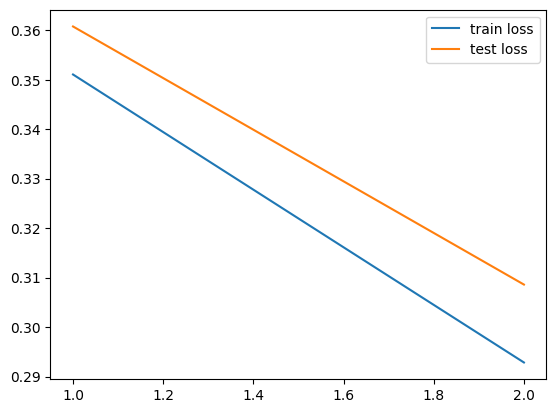

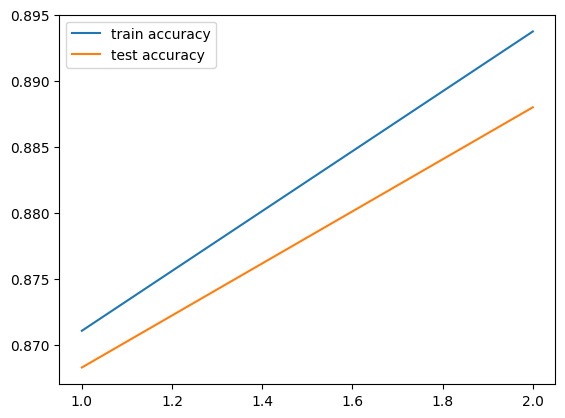

([6,
  8,
  8,
  7,
  4,
  9,
  6,
  6,
  2,
  1,
  3,
  6,
  1,
  6,
  7,
  0,
  3,
  1,
  2,
  8,
  4,
  5,
  5,
  0,
  1,
  9,
  6,
  4,
  1,
  2,
  1,
  0,
  6,
  1,
  7,
  8,
  2,
  0,
  2,
  5,
  0,
  0,
  4,
  5,
  2,
  2,
  0,
  0,
  7,
  2,
  2,
  7,
  1,
  6,
  7,
  3,
  8,
  6,
  6,
  2,
  1,
  1,
  4,
  5,
  9,
  1,
  3,
  5,
  7,
  7,
  9,
  0,
  9,
  6,
  7,
  1,
  6,
  5,
  6,
  2,
  7,
  2,
  7,
  0,
  0,
  5,
  5,
  3,
  4,
  8,
  9,
  7,
  2,
  5,
  5,
  1,
  9,
  4,
  1,
  0,
  2,
  9,
  4,
  1,
  6,
  9,
  3,
  3,
  2,
  3,
  2,
  0,
  2,
  4,
  2,
  0,
  6,
  7,
  2,
  4,
  7,
  7,
  5,
  6,
  4,
  1,
  3,
  6,
  2,
  6,
  6,
  7,
  7,
  5,
  9,
  7,
  6,
  6,
  9,
  7,
  8,
  5,
  0,
  3,
  7,
  9,
  5,
  1,
  5,
  8,
  0,
  3,
  2,
  4,
  5,
  4,
  8,
  8,
  7,
  4,
  7,
  2,
  8,
  1,
  2,
  8,
  0,
  3,
  0,
  7,
  0,
  7,
  8,
  1,
  1,
  5,
  4,
  6,
  3,
  3,
  2,
  8,
  0,
  7,
  8,
  4,
  3,
  3,
  5,
  9,
  6,
  7,
  1,
  7,
  3,
  7,
  1,
  8,
  3,
  9,


In [11]:
model = Var1()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses_train = []
losses_test = []

train_test_loop(model, criterion, optimizer, epochs)